In [1]:
import os
import matplotlib.pyplot as plt
os.chdir("../")

In [2]:
import numpy

In [3]:
from evaluation.eval_utils import show_retrieval_metrics
import json
def load_examples(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)


In [4]:
custom_result = load_examples("results/qwen-100_lpert-5_qwen06-100_lpert-5_qwen4.json")
qwen_result = load_examples("results/qwen06-100_qwen06-5_qwen06-100_qwen06-5_qwen4.json")

In [9]:
custom_result.keys()

dict_keys(['meta', 'retriever_scores', 'reranker_scores', 'line_retriever_scores', 'line_reranker_scores', 'reasoner_result', 'reasoner_score'])

In [10]:
def plot_pipeline_metrics_2x2(
    cutoff_list,
    doc_scores_dict,   # {"Retriever": ..., "Reranker": ...}
    line_scores_dict,  # {"Retriever": ..., "Reranker": ...}
    rerank_at_k = 5,
):
    """
    Plots a 2x2 comparison grid: (Doc-NDCG, Doc-Hit), (Line-NDCG, Line-Hit).
    Args:
        cutoff_list: List of cutoff values (n).
        doc_scores_dict: Dict of module name -> scores_at_n (for doc).
        line_scores_dict: Dict of module name -> scores_at_n (for line).
    """
    doc_labels=set(doc_scores_dict.keys())
    line_labels=set(line_scores_dict.keys())
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    # --- Doc NDCG
    for label in doc_labels:
        scores = doc_scores_dict[label]
        avg_ndcg = [sum(scores[n]["ndcg"]) / len(scores[n]["ndcg"]) for n in cutoff_list]
        axs[0, 0].plot(cutoff_list, avg_ndcg, marker='o', label=label)
    axs[0, 0].set_title("Document-level NDCG@n")
    axs[0, 0].set_xlabel("Top-n")
    axs[0, 0].set_ylabel("NDCG")
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    # --- Doc Hit Rate
    for label in doc_labels:
        scores = doc_scores_dict[label]
        avg_hit = [sum(scores[n]["hit"]) / len(scores[n]["hit"]) for n in cutoff_list]
        axs[0, 1].plot(cutoff_list, avg_hit, marker='o', label=label)
    axs[0, 1].set_title("Document-level HitRate@n")
    axs[0, 1].set_xlabel("Top-n")
    axs[0, 1].set_ylabel("Hit Rate")
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # --- Line NDCG
    for label in line_labels:
        scores = line_scores_dict[label]
        avg_ndcg = [sum(scores[n]["ndcg"]) / len(scores[n]["ndcg"]) for n in cutoff_list]
        axs[1, 0].plot(cutoff_list, avg_ndcg, marker='o', label=label)
    axs[1, 0].set_title("Line-level NDCG@n")
    axs[1, 0].set_xlabel("Top-n")
    axs[1, 0].set_ylabel("NDCG")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # --- Line Hit Rate
    for label in line_labels:
        scores = line_scores_dict[label]
        avg_hit = [sum(scores[n]["hit"]) / len(scores[n]["hit"]) for n in cutoff_list]
        axs[1, 1].plot(cutoff_list, avg_hit, marker='o', label=label)
    axs[1, 1].set_title("Line-level HitRate@n")
    axs[1, 1].set_xlabel("Top-n")
    axs[1, 1].set_ylabel("Hit Rate")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()



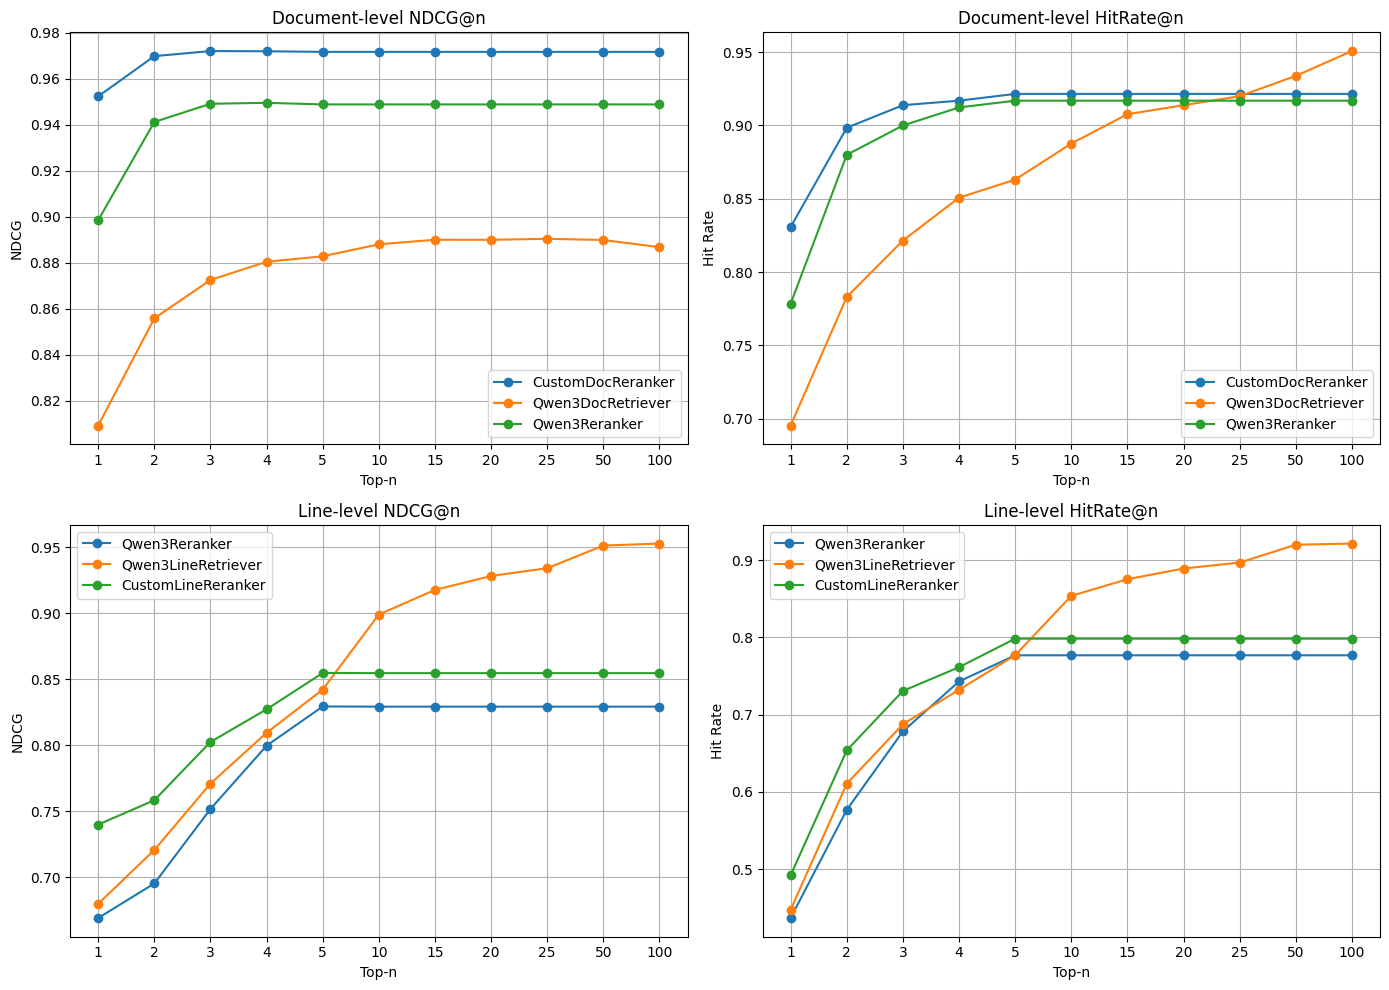

In [11]:
# --- Example usage ---
#custom_result,qwen_result
cutoff_list = [str(num) for num in custom_result['meta']['cutoff_list']]
doc_scores_dict = {"Qwen3DocRetriever": custom_result['retriever_scores'],
                   "Qwen3Reranker": qwen_result['reranker_scores'],
                   "CustomDocReranker": custom_result['reranker_scores']}
line_scores_dict={"Qwen3LineRetriever": custom_result['line_retriever_scores'], 
                  "Qwen3Reranker": qwen_result['line_reranker_scores'],
                  "CustomLineReranker": custom_result['line_reranker_scores']}
# Example usage:
plot_pipeline_metrics_2x2(
    cutoff_list,
    doc_scores_dict=doc_scores_dict,
    line_scores_dict=line_scores_dict
)

In [16]:
import pandas as pd

def summarize_scores_table_pd(
    cutoff_list,
    module_scores,
    label_modules=None,
    title="METRICS TABLE"
):
    """
    Returns:
        df_modules: DataFrame with columns ['module', 'cutoff', 'NDCG', 'HitRate']
        df_labels:  DataFrame with columns ['module', 'Precision', 'Recall', 'F1'] (if label_modules is given)
    """
    # 1. Collect module/cutoff/metrics rows
    module_rows = []
    for module_name, scores_dict in module_scores.items():
        for n in cutoff_list:
            ndcgs = scores_dict[n]["ndcg"]
            hits = scores_dict[n]["hit"]
            avg_ndcg = sum(ndcgs) / len(ndcgs) if ndcgs else 0.0
            avg_hit = sum(hits) / len(hits) if hits else 0.0
            module_rows.append({
                "module": module_name,
                "cutoff": n,
                "NDCG": avg_ndcg,
                "HitRate": avg_hit
            })
    df_modules = pd.DataFrame(module_rows)

    # 2. Collect label metrics rows (if present)
    df_labels = None
    if label_modules:
        label_metrics_rows = []
        for module_name, metrics in label_modules.items():
            metric_row = {"module": module_name}
            for k, v in metrics.items():
                if k == 'labels':
                    continue
                if isinstance(v, list):
                    avg = sum(v) / len(v) if v else 0.0
                    metric_row[k.capitalize()] = avg
                else:
                    metric_row[k.capitalize()] = v
            label_metrics_rows.append(metric_row)
        df_labels = pd.DataFrame(label_metrics_rows)

    return (df_modules, df_labels) if label_modules else (df_modules,)

# Example usage:
# df_modules, df_labels = summarize_scores_table_pd(cutoff_list, module_scores, label_modules)
# display(df_modules)
# if df_labels is not None: display(df_labels)

In [17]:
module_scores = {**doc_scores_dict, **line_scores_dict} 
label_modules = {
    "Reasoner": qwen_result['reasoner_score'],
}
cutoff_list = ['1', '5']

In [19]:
module1,label1 = summarize_scores_table_pd(
    cutoff_list=cutoff_list,
    module_scores=module_scores,
    label_modules=label_modules,
    title="FULL PIPELINE COMPARISON"
)

In [20]:
module1

,module,cutoff,NDCG,HitRate
0,Qwen3DocRetriever,1,0.809231,0.695385
1,Qwen3DocRetriever,5,0.882789,0.863077
2,Qwen3Reranker,1,0.669231,0.436923
3,Qwen3Reranker,5,0.829462,0.776923
4,CustomDocReranker,1,0.952308,0.830769
5,CustomDocReranker,5,0.971637,0.921538
6,Qwen3LineRetriever,1,0.680000,0.447692
7,Qwen3LineRetriever,5,0.842256,0.776923
8,CustomLineReranker,1,0.740000,0.492308
9,CustomLineReranker,5,0.854846,0.798462


In [21]:
label1

,module,Precision,Recall,F1
0,Reasoner,1.0,0.371604,0.526841
